## Testing P2P Network Services

Common configuration is in the notebook_utils/config_common.py file that is imported in the following cell. Please edit that file to config your invironment.

In [1]:
import os
import sys
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

#import fabric_notebook_config as notebook
import fabric_notebook_utils as utils
#import fabric_vm_utils as vm_utils



Bastion Public Addr:           bastion-1.fabric-testbed.net
Bastion Private IPv4 Addr:     192.168.11.226
Bastion Private IPv6 Addr:     2600:2701:5000:a902::c
Bastion Username:              pruth
Bastion Private Keyfile:       /Users/pruth/.ssh/id_rsa_fabric
Experiment Private Keyfile:    /Users/pruth/.ssh/id_rsa
Experiment Public Keyfile:     /Users/pruth/.ssh/id_rsa.pub
FABRIC Credential Manager:     cm.fabric-testbed.net
FABRIC Orchestrator:           orchestrator.fabric-testbed.net


## Create Slice Manager Object

In [2]:
slice_manager = SliceManager(oc_host=utils.orchestrator_host, 
                             cm_host=utils.credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [3]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 176/192 , ram: 1,456/1,536 G, disk: 60,200/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 7,680/9,600 G, unit: 8/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 377/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { 

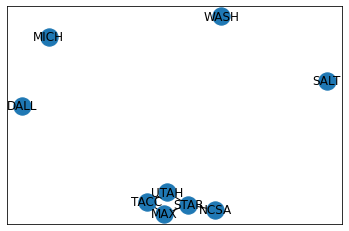

In [4]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice
In Release 1.0, user is expected to assign the IP addresses manually. Please use the example comands indicated below:

## Configure Slice Parameters



In [6]:
#Set test sites all pairs
all_sites = [ 'STAR', 'NCSA', 'UTAH','MAX' , 'TACC']
remaining_sites = all_sites.copy()
site_tests = []
for s1 in all_sites:
    remaining_sites.remove(s1)
    for s2 in remaining_sites:
        site_tests.append((s1,s2))
        
print("site_tests: {}".format(site_tests))

# set site_test manually
site_tests = [ ('STAR','UTAH'),('STAR','MAX'), ('STAR','TACC')]


#node1_name = 'Node1'
#node2_name = 'Node2'
network_service_name='p2p1'
#nic1_name = 'node1-nic1'
#nic2_name = 'node2-nic1'
username='centos'
image = 'default_centos_8'
#username='ubuntu'
#image = 'default_ubuntu_20'
image_type = 'qcow2'
cores = 2
ram = 8
disk = 10

site_tests: [('STAR', 'NCSA'), ('STAR', 'UTAH'), ('STAR', 'MAX'), ('STAR', 'TACC'), ('NCSA', 'UTAH'), ('NCSA', 'MAX'), ('NCSA', 'TACC'), ('UTAH', 'MAX'), ('UTAH', 'TACC'), ('MAX', 'TACC')]


### Utility Functions

In [7]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType

def create_p2p_slice(node1_site=None, node2_site=None, slice_name='P2Ptest', n1_component_type=ComponentModelType.SmartNIC_ConnectX_5, n2_component_type=ComponentModelType.SmartNIC_ConnectX_5):

    node1_name = node1_site+'Node'
    node2_name = node2_site+'Node'
    nic1_name = node1_name+'-nic1'
    nic2_name = node2_name+'-nic1'
    
    
    # Create topology
    t = ExperimentTopology()

    # Add node
    n1 = t.add_node(name=node1_name, site=node1_site)

    # Set capacities
    cap = Capacities()
    cap.set_fields(core=cores, ram=ram, disk=disk)

    # Set Properties
    n1.set_properties(capacities=cap, image_type=image_type, image_ref=image)

    # Add node
    n2 = t.add_node(name=node2_name, site=node2_site)

    # Set properties
    n2.set_properties(capacities=cap, image_type=image_type, image_ref=image)

    # Shared Cards
    n1.add_component(model_type=n1_component_type, name=nic1_name)
    n2.add_component(model_type=n2_component_type, name=nic2_name)

    if_labels = n1.interface_list[0].get_property(pname="labels")
    if_labels.vlan = "200"
    n1.interface_list[0].set_properties(labels=if_labels)
    if_labels = n2.interface_list[0].get_property(pname="labels")
    if_labels.vlan = "200"
    n2.interface_list[0].set_properties(labels=if_labels)

    # L2PTP Service
    t.add_network_service(name='ptp1', nstype=ServiceType.L2PTP,
                          interfaces=[n1.interface_list[0], n2.interface_list[0]])



    # Generate Slice Graph
    slice_graph = t.serialize()

    # Request slice from Orchestrator
    return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                                slice_graph=slice_graph, 
                                                ssh_key=utils.ssh_key_pub)

    if return_status == Status.OK:
        slice_id = slice_reservations[0].get_slice_id()
        print("Submitted slice creation request. Slice ID: {}".format(slice_id))
    else:
        print(f"Failure: {slice_reservations}")
        
    return slice_id

def print_nodes(verbose=False):
    return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

    for node_name, node in experiment_topology.nodes.items():
        if verbose:
            print("Node:")
            print("   Name              : {}".format(node.name))
            print("   Cores             : {}".format(node.get_property(pname='capacity_allocations').core))
            print("   RAM               : {}".format(node.get_property(pname='capacity_allocations').ram))
            print("   Disk              : {}".format(node.get_property(pname='capacity_allocations').disk))
            print("   Image             : {}".format(node.image_ref))
            print("   Image Type        : {}".format(node.image_type))
            print("   Host              : {}".format(node.get_property(pname='label_allocations').instance_parent))
            print("   Site              : {}".format(node.site))
            print("   Management IP     : {}".format(node.management_ip))
            print("   Reservation ID    : {}".format(node.get_property(pname='reservation_info').reservation_id))
            print("   Reservation State : {}".format(node.get_property(pname='reservation_info').reservation_state))
            print("   Components        : {}".format(node.components))
            print("   Interfaces        : {}".format(node.interfaces))
            print()    
        else:
            print("{}: manegement_ip: {}".format(node.name,node.management_ip))
        
def configure_nodes():
    return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)   

    for node_name, node in experiment_topology.nodes.items():
        management_ip = str(node.management_ip)

        stdout = utils.execute_script(username, node, 'sudo yum install -q -y python3 python3-netifaces')
        #print("stdout: {}".format(stdout))

        file_attributes = utils.upload_file(username, node, 'fabric_vm_utils.py','fabric_vm_utils.py')
        #print("file_attributes: {}".format(file_attributes))
        
def run_tests(node1_name,node2_name):
    import ast

    return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)   


    #for node_name, node in experiment_topology.nodes.items():
    #Node1
    node1 = experiment_topology.nodes[node1_name]
    node_ip = '192.168.1.1'
    node_cidr = '24'
    management_ip = str(node1.management_ip)

    print("{}: manegement_ip: {}".format(node1.name,node1.management_ip), end='')
    stdout = utils.execute_script(username, node1, 'sudo python3 fabric_vm_utils.py {} {} {}'.format('get_management_iface',node_ip,node_cidr) )
    print(", management_iface: {}".format(stdout), end='')

    stdout = utils.execute_script(username, node1, 'sudo python3 fabric_vm_utils.py {} {} {}'.format('get_datalane_ifaces',node_ip,node_cidr) )
    #print("stdout: {}".format(stdout))
    dataplane_ifaces = ast.literal_eval(stdout) 
    print("dataplane_ifaces: {}".format(dataplane_ifaces))
    #for iface in dataplane_ifaces:
        #print("dataplane iface: {}".format(iface))
        #stdout = utils.execute_script('ubuntu', node, 'sudo python3 fabric_vm_utils.py {} {} {}'.format('delete_vlan_iface', iface, 200) )

    
    #Node2
    node2 = experiment_topology.nodes[node2_name]
    node_ip = '192.168.1.2'
    node_cidr = '24'
    management_ip = str(node2.management_ip)

    print("{}: manegement_ip: {}".format(node2.name,node2.management_ip), end='')
    stdout = utils.execute_script(username, node2, 'sudo python3 fabric_vm_utils.py {} {} {}'.format('get_management_iface',node_ip,node_cidr) )
    print(", management_iface: {}".format(stdout), end='')

    stdout = utils.execute_script(username, node2, 'sudo python3 fabric_vm_utils.py {} {} {}'.format('get_datalane_ifaces',node_ip,node_cidr) )
    #print("stdout: {}".format(stdout))
    dataplane_ifaces = ast.literal_eval(stdout) 
    print("dataplane_ifaces: {}".format(dataplane_ifaces))
    #for iface in dataplane_ifaces:
        #print("dataplane iface: {}".format(iface))
        #stdout = utils.execute_script('ubuntu', node, 'sudo python3 fabric_vm_utils.py {} {} {}'.format('delete_vlan_iface', iface, 200) )
   

    #Find Mapping
    utils.find_nic_mapping(node1=node1, node1_username=username, node1_vlan='200',  
                           node2=node2, node2_username=username, node2_vlan='200')


## Run Experiment

In [8]:
import time

for test in site_tests:
    node1_site = test[0]
    node2_site = test[1]

    slice_name='P2PTest_{}_{}'.format(node1_site,node2_site)
    print("XXXXXXXXXXXXXXXXXX P2P Test: {} <-> {} XXXXXXXXXXXXXXXXXX".format(node1_site,node2_site))
    try:
        create_p2p_slice(node1_site=node1_site, 
                         node2_site=node2_site, 
                         slice_name=slice_name, 
                         n1_component_type=ComponentModelType.SmartNIC_ConnectX_5, 
                         n2_component_type=ComponentModelType.SmartNIC_ConnectX_5)


        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            slice = utils.wait_for_slice(slice, timeout=300, progress=True, slice_manager=slice_manager)

        print()
        print("Slice Name : {}".format(slice.slice_name))
        print("ID         : {}".format(slice.slice_id))
        print("State      : {}".format(slice.slice_state))
        print("Lease End  : {}".format(slice.lease_end))

        time.sleep(30)

        node1_name = node1_site+'Node'
        node2_name = node2_site+'Node'

        print_nodes()  
        configure_nodes()
        run_tests(node1_name,node2_name)

    except Exception as e:
        print("Error Running Test: {}".format(str(e)))
        
    try:
        #Delete Slice
        return_status, result = slice_manager.delete(slice_object=slice)

        print("Response Status {}".format(return_status))
        print("Response received {}".format(result))
        time.sleep(10)
    except Exception as e:
        print("Error Deleting Slice: {}".format(str(e)))
   

XXXXXXXXXXXXXXXXXX P2P Test: STAR <-> UTAH XXXXXXXXXXXXXXXXXX
Submitted slice creation request. Slice ID: 4776a2de-04e4-4f10-bc35-e5cec95f13df
Waiting for slice .......... Slice state: StableOK

Slice Name : P2PTest_STAR_UTAH
ID         : 4776a2de-04e4-4f10-bc35-e5cec95f13df
State      : StableOK
Lease End  : 2021-11-19 16:35:44
STARNode: manegement_ip: 2001:400:a100:3030:f816:3eff:feef:8e44
UTAHNode: manegement_ip: 2001:1948:417:7:f816:3eff:fe5f:effa
STARNode: manegement_ip: 2001:400:a100:3030:f816:3eff:feef:8e44, management_iface: ['eth0']
dataplane_ifaces: ['eth1', 'eth2']
UTAHNode: manegement_ip: 2001:1948:417:7:f816:3eff:fe5f:effa, management_iface: ['eth0']
dataplane_ifaces: ['eth1', 'eth2']
node1_dataplane_ifaces: ['eth1', 'eth2']
node2_dataplane_ifaces: ['eth1', 'eth2']
Fail! Node1: eth1.200, Node2: eth1.200, Fail! 
Fail! Node1: eth1.200, Node2: eth2.200, Fail! 
Fail! Node1: eth2.200, Node2: eth1.200, Fail! 
Fail! Node1: eth2.200, Node2: eth2.200, Fail! 
Response Status Status.

## Delete Slice

In [ ]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))